In [19]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from tqdm import tqdm
import time
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score


In [21]:

# Check for GPU availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

if device.type == 'cuda':
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"CUDA Version: {torch.version.cuda}")
    print(f"Memory Available: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")


Using device: cuda
GPU: GeForce RTX 2060
CUDA Version: 11.3
Memory Available: 6.44 GB


In [23]:
# Define data augmentation and transforms
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.3),
    transforms.RandomRotation(degrees=10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


In [25]:
def load_data(train_dir, test_dir, batch_size=64):
    """Load data with optimized settings for GPU acceleration"""
    # Load datasets with augmentation for training
    train_dataset = datasets.ImageFolder(train_dir, transform=train_transform)
    test_dataset = datasets.ImageFolder(test_dir, transform=test_transform)
    
    # Print dataset information
    print(f"Found {len(train_dataset)} training images in {len(train_dataset.classes)} classes")
    print(f"Found {len(test_dataset)} testing images in {len(test_dataset.classes)} classes")
    
    # Create data loaders with optimized settings for GPU
    train_loader = DataLoader(
        train_dataset, 
        batch_size=batch_size, 
        shuffle=True, 
        num_workers=4,  # Increased for faster data loading
        pin_memory=True,
        prefetch_factor=2  # Prefetch batches for improved performance
    )
    
    test_loader = DataLoader(
        test_dataset, 
        batch_size=batch_size, 
        shuffle=False, 
        num_workers=4, 
        pin_memory=True
    )
    
    return train_loader, test_loader, train_dataset.classes


In [27]:


# Define an enhanced CNN model
class ArSLNet(nn.Module):
    def __init__(self, num_classes):
        super(ArSLNet, self).__init__()
        
        # Feature extraction layers
        self.features = nn.Sequential(
            # Conv Block 1
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            # Conv Block 2
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            # Conv Block 3
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            # Conv Block 4
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        
        # Adaptive pooling to handle different input sizes
        self.adaptive_pool = nn.AdaptiveAvgPool2d((7, 7))
        
        # Classification layers
        self.classifier = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(256 * 7 * 7, 512),
            nn.ReLU(inplace=True),
            nn.BatchNorm1d(512),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.adaptive_pool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x


In [29]:


# Training function with GPU optimization
def train_epoch(model, train_loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    pbar = tqdm(train_loader, desc="Training")
    for inputs, labels in pbar:
        # Move data to GPU
        inputs, labels = inputs.to(device), labels.to(device)
        
        # Zero gradients
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        
        # Backward pass and optimize
        loss.backward()
        optimizer.step()
        
        # Statistics
        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
        
        # Update progress bar
        pbar.set_postfix({"loss": f"{loss.item():.4f}", "acc": f"{100.*correct/total:.2f}%"})
    
    epoch_loss = running_loss / len(train_loader)
    accuracy = 100. * correct / total
    return epoch_loss, accuracy


In [31]:

# Evaluation function
def evaluate(model, test_loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for inputs, labels in tqdm(test_loader, desc="Evaluating"):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
    
    epoch_loss = running_loss / len(test_loader)
    accuracy = 100. * correct / total
    return epoch_loss, accuracy


In [33]:

# Generate comprehensive evaluation metrics
def generate_evaluation_report(model, test_loader, device, class_names):
    """Generate comprehensive evaluation including confusion matrix and classification report"""
    model.eval()
    all_preds = []
    all_labels = []
    
    # Collect all predictions and labels
    with torch.no_grad():
        for inputs, labels in tqdm(test_loader, desc="Generating evaluation metrics"):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = outputs.max(1)
            
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    # Convert to numpy arrays
    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)
    
    # Calculate metrics
    acc = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds, average='weighted')
    recall = recall_score(all_labels, all_preds, average='weighted')
    f1 = f1_score(all_labels, all_preds, average='weighted')
    
    # Generate classification report
    report = classification_report(all_labels, all_preds, target_names=class_names, output_dict=True)
    
    # Create confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    
    print("\n===== Evaluation Metrics =====")
    print(f"Accuracy: {acc:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    
    # Plot confusion matrix
    plt.figure(figsize=(16, 14))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.savefig('confusion_matrix.png', dpi=300, bbox_inches='tight')
    
    # Save classification report as CSV
    report_df = pd.DataFrame(report).transpose()
    report_df.to_csv('classification_report.csv')
    
    return {
        'accuracy': acc,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'report': report,
        'confusion_matrix': cm
    }

In [35]:


# Main training function
def train_model(train_dir, test_dir, num_epochs=64, batch_size=64, lr=0.001):
    # Load data
    train_loader, test_loader, class_names = load_data(train_dir, test_dir, batch_size)
    num_classes = len(class_names)
    
    # Initialize model
    model = ArSLNet(num_classes=num_classes).to(device)
    print(f"Model initialized with {num_classes} output classes")
    
    # Loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-5)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='min', patience=5, factor=0.1, verbose=True
    )
    
    # Early stopping parameters
    early_stopping_patience = 10  # Number of epochs to wait after validation loss stops improving
    early_stopping_counter = 0
    best_val_loss = float('inf')
    
    # Training loop
    train_losses, test_losses = [], []
    train_accuracies, test_accuracies = [], []
    best_acc = 0.0
    
    # Create output directory for models
    os.makedirs('models', exist_ok=True)
    
    # Training timer
    start_time = time.time()
    
    for epoch in range(num_epochs):
        print(f"\nEpoch {epoch+1}/{num_epochs}")
        
        # Train one epoch
        train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
        train_losses.append(train_loss)
        train_accuracies.append(train_acc)
        
        # Evaluate
        test_loss, test_acc = evaluate(model, test_loader, criterion, device)
        test_losses.append(test_loss)
        test_accuracies.append(test_acc)
        
        # Adjust learning rate
        scheduler.step(test_loss)
        
        # Save best model
        if test_acc > best_acc:
            best_acc = test_acc
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'accuracy': best_acc,
                'class_names': class_names
            }, 'models/best_arsl_model.pth')
            print(f"New best model saved! Accuracy: {best_acc:.2f}%")
        
        # Print stats
        print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%")
        print(f"Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.2f}%")
        
        # Check for early stopping
        if test_loss < best_val_loss:
            best_val_loss = test_loss
            early_stopping_counter = 0
        else:
            early_stopping_counter += 1
            print(f"EarlyStopping counter: {early_stopping_counter} out of {early_stopping_patience}")
            
            if early_stopping_counter >= early_stopping_patience:
                print(f"Early stopping triggered after {epoch+1} epochs")
                break
        
        # Save checkpoint every 5 epochs
        if (epoch + 1) % 5 == 0:
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'train_loss': train_loss,
                'test_loss': test_loss,
                'train_acc': train_acc,
                'test_acc': test_acc,
                'class_names': class_names
            }, f'models/arsl_checkpoint_epoch_{epoch+1}.pth')
        
        # Clear GPU cache
        if torch.cuda.is_available():
            torch.cuda.empty_cache()
    
    # Calculate total training time
    total_time = time.time() - start_time
    hours, remainder = divmod(total_time, 3600)
    minutes, seconds = divmod(remainder, 60)
    print(f"\nTraining completed in {int(hours)}h {int(minutes)}m {int(seconds)}s")
    
    # Plot training history
    plt.figure(figsize=(16, 6))
    
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(test_losses, label='Test Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.7)
    
    plt.subplot(1, 2, 2)
    plt.plot(train_accuracies, label='Train Accuracy')
    plt.plot(test_accuracies, label='Test Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.title('Training and Validation Accuracy')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.7)
    
    plt.tight_layout()
    plt.savefig('training_history.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # Generate comprehensive evaluation report
    print("\nGenerating comprehensive evaluation report...")
    evaluation_metrics = generate_evaluation_report(model, test_loader, device, class_names)
    
    # Save entire pipeline
    pipeline = {
        'model': model.state_dict(),
        'class_names': class_names,
        'history': {
            'train_losses': train_losses,
            'test_losses': test_losses,
            'train_accuracies': train_accuracies,
            'test_accuracies': test_accuracies,
        },
        'metrics': {
            'best_accuracy': best_acc,
            'final_train_loss': train_losses[-1],
            'final_test_loss': test_losses[-1],
            'final_train_acc': train_accuracies[-1],
            'final_test_acc': test_accuracies[-1],
            'training_time': total_time
        }
    }
    torch.save(pipeline, 'models/complete_arsl_pipeline.pth')
    print("Complete pipeline saved to 'models/complete_arsl_pipeline.pth'")
    
    print(f"\nBest Test Accuracy: {best_acc:.2f}%")
    
    return model, evaluation_metrics



Found 49160 training images in 32 classes
Found 26491 testing images in 32 classes
Model initialized with 32 output classes

Epoch 1/64


Evaluating: 100%|████████████████████████████████████████████████████████████████████| 414/414 [00:45<00:00,  9.08it/s]


New best model saved! Accuracy: 58.55%
Train Loss: 2.4104, Train Acc: 31.46%
Test Loss: 1.4254, Test Acc: 58.55%

Epoch 2/64


Evaluating: 100%|████████████████████████████████████████████████████████████████████| 414/414 [01:20<00:00,  5.17it/s]


New best model saved! Accuracy: 69.05%
Train Loss: 1.4815, Train Acc: 55.90%
Test Loss: 1.0427, Test Acc: 69.05%

Epoch 3/64


Evaluating: 100%|████████████████████████████████████████████████████████████████████| 414/414 [01:20<00:00,  5.15it/s]


New best model saved! Accuracy: 73.05%
Train Loss: 1.1779, Train Acc: 64.61%
Test Loss: 0.9577, Test Acc: 73.05%

Epoch 4/64


Evaluating: 100%|████████████████████████████████████████████████████████████████████| 414/414 [00:40<00:00, 10.16it/s]


New best model saved! Accuracy: 80.90%
Train Loss: 0.9640, Train Acc: 70.78%
Test Loss: 0.6609, Test Acc: 80.90%

Epoch 5/64


Evaluating: 100%|████████████████████████████████████████████████████████████████████| 414/414 [00:40<00:00, 10.20it/s]


New best model saved! Accuracy: 82.18%
Train Loss: 0.8266, Train Acc: 74.62%
Test Loss: 0.5900, Test Acc: 82.18%

Epoch 6/64


Evaluating: 100%|████████████████████████████████████████████████████████████████████| 414/414 [00:40<00:00, 10.22it/s]


New best model saved! Accuracy: 86.15%
Train Loss: 0.7524, Train Acc: 76.44%
Test Loss: 0.4587, Test Acc: 86.15%

Epoch 7/64


Evaluating: 100%|████████████████████████████████████████████████████████████████████| 414/414 [00:40<00:00, 10.27it/s]


Train Loss: 0.6396, Train Acc: 80.10%
Test Loss: 0.4676, Test Acc: 85.79%
EarlyStopping counter: 1 out of 10

Epoch 8/64


Evaluating: 100%|████████████████████████████████████████████████████████████████████| 414/414 [00:40<00:00, 10.26it/s]


New best model saved! Accuracy: 89.34%
Train Loss: 0.5787, Train Acc: 82.06%
Test Loss: 0.3552, Test Acc: 89.34%

Epoch 9/64


Evaluating: 100%|████████████████████████████████████████████████████████████████████| 414/414 [00:40<00:00, 10.29it/s]


New best model saved! Accuracy: 89.54%
Train Loss: 0.5329, Train Acc: 83.19%
Test Loss: 0.3388, Test Acc: 89.54%

Epoch 10/64


Evaluating: 100%|████████████████████████████████████████████████████████████████████| 414/414 [00:40<00:00, 10.23it/s]


New best model saved! Accuracy: 90.15%
Train Loss: 0.4849, Train Acc: 84.60%
Test Loss: 0.3166, Test Acc: 90.15%

Epoch 11/64


Evaluating: 100%|████████████████████████████████████████████████████████████████████| 414/414 [00:40<00:00, 10.21it/s]


New best model saved! Accuracy: 91.73%
Train Loss: 0.4430, Train Acc: 85.83%
Test Loss: 0.2642, Test Acc: 91.73%

Epoch 12/64


Evaluating: 100%|████████████████████████████████████████████████████████████████████| 414/414 [00:40<00:00, 10.22it/s]


New best model saved! Accuracy: 92.57%
Train Loss: 0.4183, Train Acc: 86.59%
Test Loss: 0.2372, Test Acc: 92.57%

Epoch 13/64


Evaluating: 100%|████████████████████████████████████████████████████████████████████| 414/414 [00:40<00:00, 10.23it/s]


Train Loss: 0.3799, Train Acc: 87.91%
Test Loss: 0.2467, Test Acc: 92.39%
EarlyStopping counter: 1 out of 10

Epoch 14/64


Evaluating: 100%|████████████████████████████████████████████████████████████████████| 414/414 [00:40<00:00, 10.22it/s]


New best model saved! Accuracy: 93.33%
Train Loss: 0.3594, Train Acc: 88.58%
Test Loss: 0.2162, Test Acc: 93.33%

Epoch 15/64


Evaluating: 100%|████████████████████████████████████████████████████████████████████| 414/414 [00:40<00:00, 10.23it/s]


New best model saved! Accuracy: 93.38%
Train Loss: 0.3407, Train Acc: 89.01%
Test Loss: 0.2129, Test Acc: 93.38%

Epoch 16/64


Evaluating: 100%|████████████████████████████████████████████████████████████████████| 414/414 [00:40<00:00, 10.19it/s]


New best model saved! Accuracy: 93.87%
Train Loss: 0.3241, Train Acc: 89.53%
Test Loss: 0.1926, Test Acc: 93.87%

Epoch 17/64


Evaluating: 100%|████████████████████████████████████████████████████████████████████| 414/414 [00:40<00:00, 10.22it/s]


New best model saved! Accuracy: 94.06%
Train Loss: 0.3171, Train Acc: 89.95%
Test Loss: 0.1881, Test Acc: 94.06%

Epoch 18/64


Evaluating: 100%|████████████████████████████████████████████████████████████████████| 414/414 [00:40<00:00, 10.23it/s]


New best model saved! Accuracy: 94.64%
Train Loss: 0.2834, Train Acc: 90.93%
Test Loss: 0.1717, Test Acc: 94.64%

Epoch 19/64


Evaluating: 100%|████████████████████████████████████████████████████████████████████| 414/414 [00:40<00:00, 10.23it/s]


Train Loss: 0.2612, Train Acc: 91.70%
Test Loss: 0.1776, Test Acc: 94.53%
EarlyStopping counter: 1 out of 10

Epoch 20/64


Evaluating: 100%|████████████████████████████████████████████████████████████████████| 414/414 [00:40<00:00, 10.21it/s]


New best model saved! Accuracy: 94.83%
Train Loss: 0.2638, Train Acc: 91.48%
Test Loss: 0.1628, Test Acc: 94.83%

Epoch 21/64


Evaluating: 100%|████████████████████████████████████████████████████████████████████| 414/414 [00:40<00:00, 10.25it/s]


New best model saved! Accuracy: 94.95%
Train Loss: 0.2610, Train Acc: 91.50%
Test Loss: 0.1586, Test Acc: 94.95%

Epoch 22/64


Evaluating: 100%|████████████████████████████████████████████████████████████████████| 414/414 [00:40<00:00, 10.24it/s]


Train Loss: 0.2373, Train Acc: 92.31%
Test Loss: 0.1774, Test Acc: 94.45%
EarlyStopping counter: 1 out of 10

Epoch 23/64


Evaluating: 100%|████████████████████████████████████████████████████████████████████| 414/414 [00:40<00:00, 10.25it/s]


Train Loss: 0.2373, Train Acc: 92.28%
Test Loss: 0.1638, Test Acc: 94.90%
EarlyStopping counter: 2 out of 10

Epoch 24/64


Evaluating: 100%|████████████████████████████████████████████████████████████████████| 414/414 [00:40<00:00, 10.22it/s]


New best model saved! Accuracy: 95.75%
Train Loss: 0.2182, Train Acc: 92.93%
Test Loss: 0.1353, Test Acc: 95.75%

Epoch 25/64


Evaluating: 100%|████████████████████████████████████████████████████████████████████| 414/414 [00:40<00:00, 10.22it/s]


Train Loss: 0.2100, Train Acc: 93.12%
Test Loss: 0.1460, Test Acc: 95.48%
EarlyStopping counter: 1 out of 10

Epoch 26/64


Evaluating: 100%|████████████████████████████████████████████████████████████████████| 414/414 [00:40<00:00, 10.26it/s]


New best model saved! Accuracy: 96.12%
Train Loss: 0.2140, Train Acc: 93.06%
Test Loss: 0.1271, Test Acc: 96.12%

Epoch 27/64


Evaluating: 100%|████████████████████████████████████████████████████████████████████| 414/414 [00:40<00:00, 10.21it/s]


Train Loss: 0.2047, Train Acc: 93.25%
Test Loss: 0.1338, Test Acc: 95.79%
EarlyStopping counter: 1 out of 10

Epoch 28/64


Evaluating: 100%|████████████████████████████████████████████████████████████████████| 414/414 [00:40<00:00, 10.26it/s]


Train Loss: 0.2063, Train Acc: 93.25%
Test Loss: 0.1264, Test Acc: 95.87%

Epoch 29/64


Evaluating: 100%|████████████████████████████████████████████████████████████████████| 414/414 [00:40<00:00, 10.23it/s]


Train Loss: 0.1855, Train Acc: 93.85%
Test Loss: 0.1278, Test Acc: 95.99%
EarlyStopping counter: 1 out of 10

Epoch 30/64


Evaluating: 100%|████████████████████████████████████████████████████████████████████| 414/414 [00:40<00:00, 10.28it/s]


New best model saved! Accuracy: 96.25%
Train Loss: 0.1844, Train Acc: 93.98%
Test Loss: 0.1204, Test Acc: 96.25%

Epoch 31/64


Evaluating: 100%|████████████████████████████████████████████████████████████████████| 414/414 [00:40<00:00, 10.28it/s]


New best model saved! Accuracy: 96.31%
Train Loss: 0.1826, Train Acc: 94.02%
Test Loss: 0.1183, Test Acc: 96.31%

Epoch 32/64


Evaluating: 100%|████████████████████████████████████████████████████████████████████| 414/414 [00:40<00:00, 10.26it/s]


Train Loss: 0.1750, Train Acc: 94.25%
Test Loss: 0.1323, Test Acc: 95.99%
EarlyStopping counter: 1 out of 10

Epoch 33/64


Evaluating: 100%|████████████████████████████████████████████████████████████████████| 414/414 [00:40<00:00, 10.18it/s]


Train Loss: 0.1749, Train Acc: 94.32%
Test Loss: 0.1310, Test Acc: 96.03%
EarlyStopping counter: 2 out of 10

Epoch 34/64


Evaluating: 100%|████████████████████████████████████████████████████████████████████| 414/414 [00:40<00:00, 10.20it/s]


Train Loss: 0.1695, Train Acc: 94.40%
Test Loss: 0.1215, Test Acc: 96.23%
EarlyStopping counter: 3 out of 10

Epoch 35/64


Evaluating: 100%|████████████████████████████████████████████████████████████████████| 414/414 [00:40<00:00, 10.28it/s]


New best model saved! Accuracy: 96.38%
Train Loss: 0.1651, Train Acc: 94.69%
Test Loss: 0.1140, Test Acc: 96.38%

Epoch 36/64


Evaluating: 100%|████████████████████████████████████████████████████████████████████| 414/414 [00:40<00:00, 10.27it/s]


New best model saved! Accuracy: 96.55%
Train Loss: 0.1566, Train Acc: 94.89%
Test Loss: 0.1112, Test Acc: 96.55%

Epoch 37/64


Evaluating: 100%|████████████████████████████████████████████████████████████████████| 414/414 [00:40<00:00, 10.27it/s]


Train Loss: 0.1597, Train Acc: 94.88%
Test Loss: 0.1145, Test Acc: 96.38%
EarlyStopping counter: 1 out of 10

Epoch 38/64


Evaluating: 100%|████████████████████████████████████████████████████████████████████| 414/414 [00:40<00:00, 10.23it/s]


New best model saved! Accuracy: 96.78%
Train Loss: 0.1528, Train Acc: 94.99%
Test Loss: 0.1013, Test Acc: 96.78%

Epoch 39/64


Evaluating: 100%|████████████████████████████████████████████████████████████████████| 414/414 [00:40<00:00, 10.27it/s]


Train Loss: 0.1495, Train Acc: 95.18%
Test Loss: 0.1125, Test Acc: 96.60%
EarlyStopping counter: 1 out of 10

Epoch 40/64


Evaluating: 100%|████████████████████████████████████████████████████████████████████| 414/414 [00:40<00:00, 10.22it/s]


Train Loss: 0.1491, Train Acc: 95.19%
Test Loss: 0.1067, Test Acc: 96.69%
EarlyStopping counter: 2 out of 10

Epoch 41/64


Evaluating: 100%|████████████████████████████████████████████████████████████████████| 414/414 [00:40<00:00, 10.29it/s]


Train Loss: 0.1462, Train Acc: 95.24%
Test Loss: 0.1231, Test Acc: 96.25%
EarlyStopping counter: 3 out of 10

Epoch 42/64


Evaluating: 100%|████████████████████████████████████████████████████████████████████| 414/414 [00:40<00:00, 10.27it/s]


Train Loss: 0.1416, Train Acc: 95.44%
Test Loss: 0.1164, Test Acc: 96.35%
EarlyStopping counter: 4 out of 10

Epoch 43/64


Evaluating: 100%|████████████████████████████████████████████████████████████████████| 414/414 [00:40<00:00, 10.26it/s]


Train Loss: 0.1437, Train Acc: 95.31%
Test Loss: 0.1082, Test Acc: 96.66%
EarlyStopping counter: 5 out of 10

Epoch 44/64


Evaluating: 100%|████████████████████████████████████████████████████████████████████| 414/414 [00:40<00:00, 10.26it/s]


Epoch 00044: reducing learning rate of group 0 to 1.0000e-04.
Train Loss: 0.1425, Train Acc: 95.37%
Test Loss: 0.1042, Test Acc: 96.75%
EarlyStopping counter: 6 out of 10

Epoch 45/64


Evaluating: 100%|████████████████████████████████████████████████████████████████████| 414/414 [00:40<00:00, 10.28it/s]


New best model saved! Accuracy: 97.54%
Train Loss: 0.0938, Train Acc: 96.97%
Test Loss: 0.0788, Test Acc: 97.54%

Epoch 46/64


Evaluating: 100%|████████████████████████████████████████████████████████████████████| 414/414 [00:40<00:00, 10.29it/s]


New best model saved! Accuracy: 97.62%
Train Loss: 0.0776, Train Acc: 97.52%
Test Loss: 0.0765, Test Acc: 97.62%

Epoch 47/64


Evaluating: 100%|████████████████████████████████████████████████████████████████████| 414/414 [00:40<00:00, 10.24it/s]


New best model saved! Accuracy: 97.70%
Train Loss: 0.0717, Train Acc: 97.73%
Test Loss: 0.0739, Test Acc: 97.70%

Epoch 48/64


Evaluating: 100%|████████████████████████████████████████████████████████████████████| 414/414 [00:40<00:00, 10.28it/s]


Train Loss: 0.0660, Train Acc: 97.90%
Test Loss: 0.0746, Test Acc: 97.70%
EarlyStopping counter: 1 out of 10

Epoch 49/64


Evaluating: 100%|████████████████████████████████████████████████████████████████████| 414/414 [00:40<00:00, 10.29it/s]


New best model saved! Accuracy: 97.83%
Train Loss: 0.0606, Train Acc: 98.02%
Test Loss: 0.0717, Test Acc: 97.83%

Epoch 50/64


Evaluating: 100%|████████████████████████████████████████████████████████████████████| 414/414 [00:40<00:00, 10.27it/s]


New best model saved! Accuracy: 97.86%
Train Loss: 0.0612, Train Acc: 98.03%
Test Loss: 0.0709, Test Acc: 97.86%

Epoch 51/64


Evaluating: 100%|████████████████████████████████████████████████████████████████████| 414/414 [00:40<00:00, 10.25it/s]


Train Loss: 0.0576, Train Acc: 98.21%
Test Loss: 0.0716, Test Acc: 97.84%
EarlyStopping counter: 1 out of 10

Epoch 52/64


Evaluating: 100%|████████████████████████████████████████████████████████████████████| 414/414 [00:40<00:00, 10.28it/s]


New best model saved! Accuracy: 97.90%
Train Loss: 0.0545, Train Acc: 98.24%
Test Loss: 0.0697, Test Acc: 97.90%

Epoch 53/64


Evaluating: 100%|████████████████████████████████████████████████████████████████████| 414/414 [00:40<00:00, 10.29it/s]


New best model saved! Accuracy: 97.94%
Train Loss: 0.0557, Train Acc: 98.25%
Test Loss: 0.0691, Test Acc: 97.94%

Epoch 54/64


Evaluating: 100%|████████████████████████████████████████████████████████████████████| 414/414 [00:40<00:00, 10.28it/s]


New best model saved! Accuracy: 97.95%
Train Loss: 0.0521, Train Acc: 98.36%
Test Loss: 0.0702, Test Acc: 97.95%
EarlyStopping counter: 1 out of 10

Epoch 55/64


Evaluating: 100%|████████████████████████████████████████████████████████████████████| 414/414 [00:40<00:00, 10.20it/s]


New best model saved! Accuracy: 97.96%
Train Loss: 0.0498, Train Acc: 98.35%
Test Loss: 0.0687, Test Acc: 97.96%

Epoch 56/64


Evaluating: 100%|████████████████████████████████████████████████████████████████████| 414/414 [00:40<00:00, 10.29it/s]


New best model saved! Accuracy: 98.00%
Train Loss: 0.0486, Train Acc: 98.37%
Test Loss: 0.0696, Test Acc: 98.00%
EarlyStopping counter: 1 out of 10

Epoch 57/64


Evaluating: 100%|████████████████████████████████████████████████████████████████████| 414/414 [00:40<00:00, 10.23it/s]


Train Loss: 0.0498, Train Acc: 98.45%
Test Loss: 0.0694, Test Acc: 97.94%
EarlyStopping counter: 2 out of 10

Epoch 58/64


Evaluating: 100%|████████████████████████████████████████████████████████████████████| 414/414 [00:40<00:00, 10.23it/s]


Train Loss: 0.0469, Train Acc: 98.54%
Test Loss: 0.0698, Test Acc: 97.91%
EarlyStopping counter: 3 out of 10

Epoch 59/64


Evaluating: 100%|████████████████████████████████████████████████████████████████████| 414/414 [00:40<00:00, 10.23it/s]


New best model saved! Accuracy: 98.04%
Train Loss: 0.0478, Train Acc: 98.42%
Test Loss: 0.0674, Test Acc: 98.04%

Epoch 60/64


Evaluating: 100%|████████████████████████████████████████████████████████████████████| 414/414 [00:40<00:00, 10.23it/s]


Train Loss: 0.0452, Train Acc: 98.57%
Test Loss: 0.0676, Test Acc: 98.03%
EarlyStopping counter: 1 out of 10

Epoch 61/64


Evaluating: 100%|████████████████████████████████████████████████████████████████████| 414/414 [00:40<00:00, 10.26it/s]


Train Loss: 0.0456, Train Acc: 98.53%
Test Loss: 0.0671, Test Acc: 98.00%

Epoch 62/64


Evaluating: 100%|████████████████████████████████████████████████████████████████████| 414/414 [00:40<00:00, 10.21it/s]


Train Loss: 0.0423, Train Acc: 98.61%
Test Loss: 0.0684, Test Acc: 97.96%
EarlyStopping counter: 1 out of 10

Epoch 63/64


Evaluating: 100%|████████████████████████████████████████████████████████████████████| 414/414 [00:40<00:00, 10.24it/s]


Train Loss: 0.0439, Train Acc: 98.57%
Test Loss: 0.0686, Test Acc: 98.03%
EarlyStopping counter: 2 out of 10

Epoch 64/64


Evaluating: 100%|████████████████████████████████████████████████████████████████████| 414/414 [00:40<00:00, 10.25it/s]


New best model saved! Accuracy: 98.06%
Train Loss: 0.0417, Train Acc: 98.66%
Test Loss: 0.0657, Test Acc: 98.06%

Training completed in 5h 3m 39s


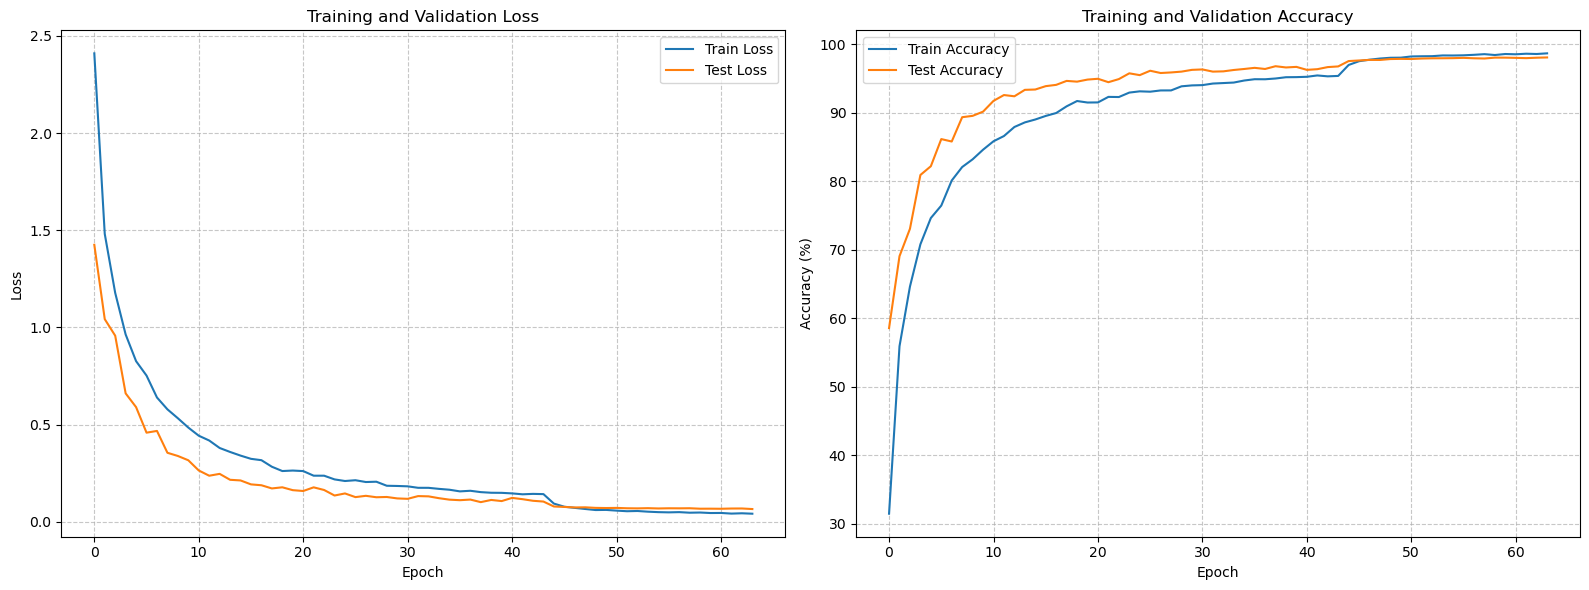


Generating comprehensive evaluation report...


Generating evaluation metrics: 100%|█████████████████████████████████████████████████| 414/414 [00:40<00:00, 10.28it/s]



===== Evaluation Metrics =====
Accuracy: 0.9806
Precision: 0.9807
Recall: 0.9806
F1 Score: 0.9806
Complete pipeline saved to 'models/complete_arsl_pipeline.pth'

Best Test Accuracy: 98.06%


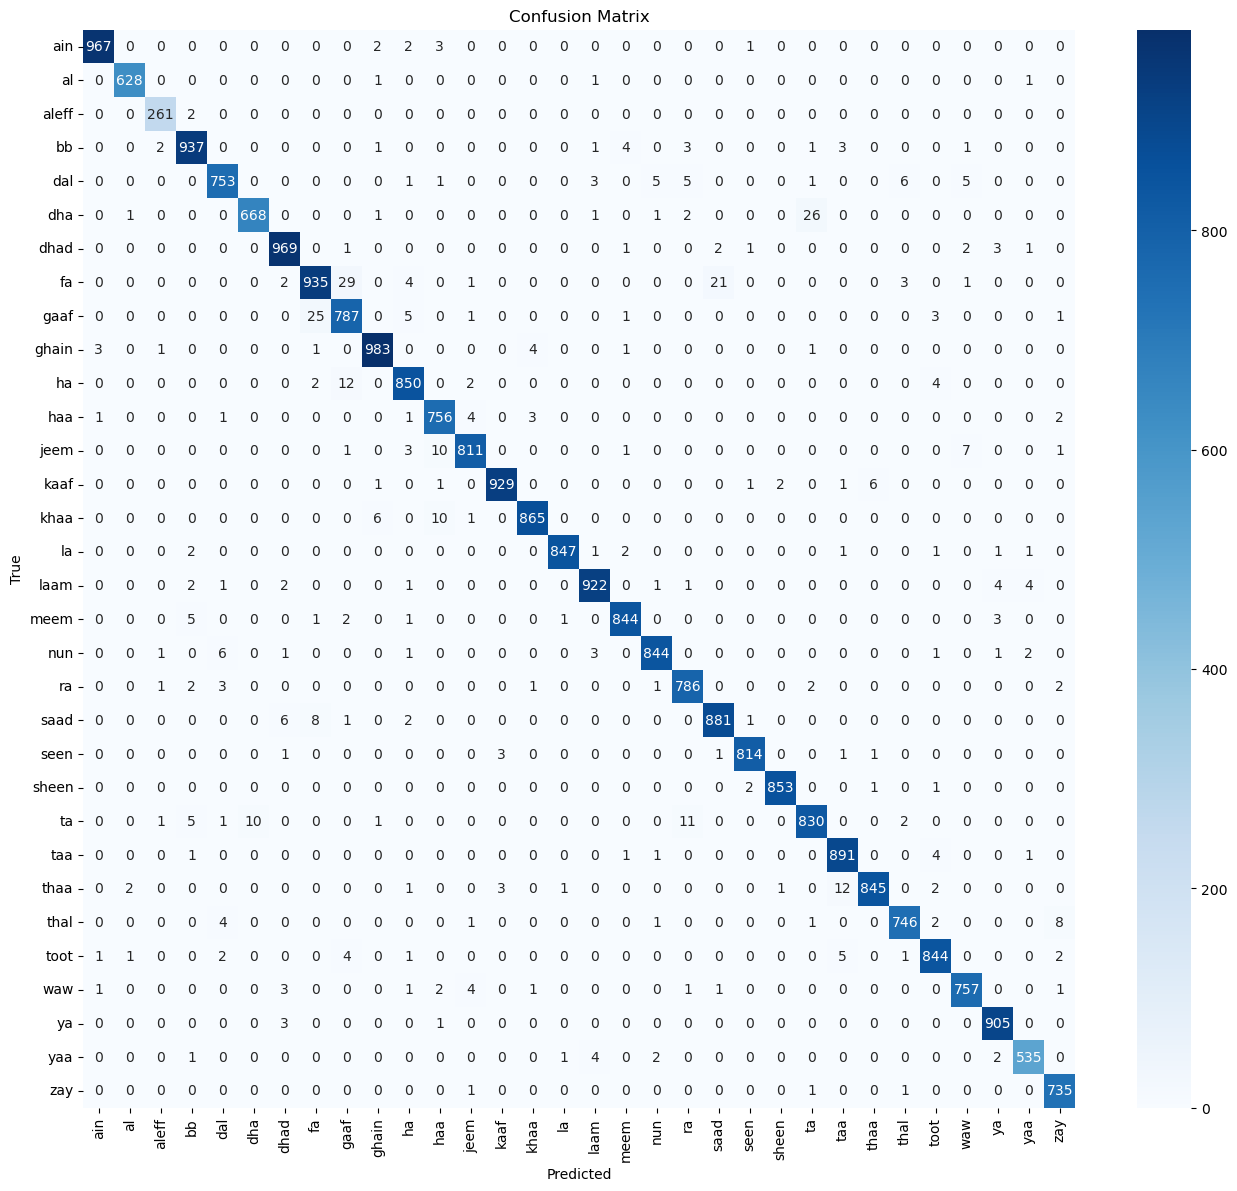

In [37]:
# Example usage
if __name__ == "__main__":
    # Set local paths
    train_dir = "C:/Users/Fatima/Downloads/train"
    test_dir = "C:/Users/Fatima/Downloads/test"
    
    # Train model with GPU acceleration
    model, evaluation_metrics = train_model(
        train_dir=train_dir,
        test_dir=test_dir,
        num_epochs=64,      # Maximum number of epochs
        batch_size=64       # Increased batch size for RTX 2060
    )

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
from tqdm import tqdm

# Define the CNN model architecture (must match the saved model)
class ArSLNet(nn.Module):
    def __init__(self, num_classes):
        super(ArSLNet, self).__init__()
        
        # Feature extraction layers
        self.features = nn.Sequential(
            # Conv Block 1
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            # Conv Block 2
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            # Conv Block 3
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            # Conv Block 4
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        
        # Adaptive pooling to handle different input sizes
        self.adaptive_pool = nn.AdaptiveAvgPool2d((7, 7))
        
        # Classification layers
        self.classifier = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(256 * 7 * 7, 512),
            nn.ReLU(inplace=True),
            nn.BatchNorm1d(512),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.adaptive_pool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

# Check for GPU availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Define transforms for test data
test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

def load_model_and_evaluate(model_path, test_dir, batch_size=64):
    """Load saved model and generate detailed evaluation report"""
    print(f"Loading model from {model_path}")
    
    # Load the model
    checkpoint = torch.load(model_path, map_location=device)
    
    # Get class names
    if 'class_names' in checkpoint:
        class_names = checkpoint['class_names']
        print(f"Found {len(class_names)} classes in the model")
    else:
        print("Class names not found in the model, trying to load from test data")
        # Will be determined from test data
        class_names = None
    
    # Load test data
    test_dataset = datasets.ImageFolder(test_dir, transform=test_transform)
    if class_names is None:
        class_names = test_dataset.classes
        print(f"Using {len(class_names)} classes from test data")
    
    test_loader = DataLoader(
        test_dataset, 
        batch_size=batch_size, 
        shuffle=False, 
        num_workers=2, 
        pin_memory=True if device.type == 'cuda' else False
    )
    
    # Initialize model
    num_classes = len(class_names)
    model = ArSLNet(num_classes=num_classes).to(device)
    
    # Load model state
    if 'model' in checkpoint:
        model.load_state_dict(checkpoint['model'])
    elif 'model_state_dict' in checkpoint:
        model.load_state_dict(checkpoint['model_state_dict'])
    else:
        raise ValueError("Could not find model weights in checkpoint")
    
    # Evaluate model
    model.eval()
    all_preds = []
    all_labels = []
    correct = 0
    total = 0
    
    print("Generating predictions...")
    with torch.no_grad():
        for inputs, labels in tqdm(test_loader):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = outputs.max(1)
            
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            
            # Calculate accuracy
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
    
    accuracy = 100. * correct / total
    print(f"Test Accuracy: {accuracy:.2f}%")
    
    # Convert to numpy arrays
    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)
    
    # Generate classification report
    print("\nGenerating classification report...")
    report_dict = classification_report(all_labels, all_preds, target_names=class_names, output_dict=True)
    report_df = pd.DataFrame(report_dict).transpose()
    
    # Print report as table
    print("\n===== Classification Report =====")
    report_table = pd.DataFrame(report_dict).transpose()
    print(report_table)
    
    # Save report to CSV
    report_df.to_csv('detailed_classification_report.csv')
    print("Classification report saved to 'detailed_classification_report.csv'")
    
    # Generate confusion matrix
    print("\nGenerating confusion matrix...")
    cm = confusion_matrix(all_labels, all_preds)
    
    # Plot and save confusion matrix
    plt.figure(figsize=(20, 18))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.savefig('detailed_confusion_matrix.png', dpi=300, bbox_inches='tight')
    print("Confusion matrix saved to 'detailed_confusion_matrix.png'")
    
    # Plot class-wise precision, recall, and F1 score
    metrics_df = report_df.iloc[:-3]  # Exclude avg rows
    metrics_df = metrics_df.sort_values(by=['f1-score'], ascending=False)
    
    plt.figure(figsize=(15, 8))
    x = np.arange(len(metrics_df))
    width = 0.25
    
    plt.bar(x - width, metrics_df['precision'], width, label='Precision')
    plt.bar(x, metrics_df['recall'], width, label='Recall')
    plt.bar(x + width, metrics_df['f1-score'], width, label='F1-score')
    
    plt.xlabel('Class')
    plt.ylabel('Score')
    plt.title('Class-wise Performance Metrics')
    plt.xticks(x, metrics_df.index, rotation=90)
    plt.legend()
    plt.tight_layout()
    plt.savefig('class_performance_metrics.png', dpi=300, bbox_inches='tight')
    print("Class performance metrics saved to 'class_performance_metrics.png'")
    
    # Print model statistics
    if 'metrics' in checkpoint:
        print("\n===== Model Training Statistics =====")
        for key, value in checkpoint['metrics'].items():
            if isinstance(value, float):
                print(f"{key}: {value:.4f}")
            else:
                print(f"{key}: {value}")
    
    return report_df, cm, class_names

if __name__ == "__main__":
    # Set paths
    model_path = "models/best_arsl_model.pth"  # Use best model
    # Alternatively, use the complete pipeline
    # model_path = "models/complete_arsl_pipeline.pth" 
    test_dir = "C:/Users/Fatima/Downloads/test"
    
    # Generate detailed reports
    report, confusion_matrix, classes = load_model_and_evaluate(model_path, test_dir)
    
    # List classes with their performance
    print("\n===== Class Performance Summary =====")
    class_performance = report.iloc[:-3][['precision', 'recall', 'f1-score']].sort_values(by='f1-score', ascending=False)
    print(class_performance)
    
    # Identify best and worst performing classes
    best_class = class_performance.iloc[0]
    worst_class = class_performance.iloc[-1]
    
    print(f"\nBest performing class: {class_performance.index[0]}")
    print(f"Precision: {best_class['precision']:.4f}, Recall: {best_class['recall']:.4f}, F1-score: {best_class['f1-score']:.4f}")
    
    print(f"\nWorst performing class: {class_performance.index[-1]}")
    print(f"Precision: {worst_class['precision']:.4f}, Recall: {worst_class['recall']:.4f}, F1-score: {worst_class['f1-score']:.4f}")

Using device: cuda
Loading model from models/best_arsl_model.pth
Found 32 classes in the model
Generating predictions...


 78%|██████████████████████████████████████████████████████████████                  | 321/414 [00:31<00:08, 11.33it/s]